# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
# check gpu status
#!nvidia-smi

In [2]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adagrad, Adam

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
def build_mlp(input_shape, output_units=10, num_neurons=[128,64]):
    """
    Build your own model
    """
    model=Sequential()
    model.add(Dense(units=input_shape[1], input_dim=input_shape[1],kernel_initializer='normal',activation='relu',name='input'))
    for i, n_units in enumerate(num_neurons):
        model.add(Dense(units=n_units,kernel_initializer='normal',activation='relu',name='hidden'+str(i+1)))
    model.add(Dense(units=output_units,kernel_initializer='normal',activation='softmax',name='output'))
    return model

In [7]:
## 超參數設定
"""
Set your required experiment parameters
"""
LEARNING_RATE = [1e-1,1e-2,1e-3]
EPOCHS = 30
BATCH_SIZE = 256
MOMENTUM = 0.9

def build_opt(opt,lr):
    if opt== 'SGD':
        return SGD(lr=lr, nesterov=True, momentum=True)
    elif opt== 'RMSprop':
        return RMSprop(lr=lr,rho=0.9,epsilon=None,decay=0.0)
    elif opt=='Adagrad':
        return Adagrad(lr=lr,epsilon=None,decay=0.0)
    elif opt== 'Adam':
        return Adam(lr=lr,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0,amsgrad=False)


In [8]:
results = {}
OPTS = ['SGD','RMSprop','Adagrad','Adam']
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
for lr in LEARNING_RATE:
    for opt in OPTS:
        keras.backend.clear_session() #把舊的graph清掉
        print(f'Current opt = {opt}, lr={lr}\n')
        
        model = build_mlp(input_shape=x_train.shape)
        model.summary()
        
        optimizer=build_opt(opt,lr)
              
        model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
        
        model.fit(x_train,y_train,
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  validation_data=(x_test,y_test),
                  shuffle=True)
              
        # collect results
        train_loss=model.history.history['loss']
        valid_loss=model.history.history['val_loss']
        train_acc =model.history.history['acc']
        valid_acc =model.history.history['val_acc']
        
        # create result dictionary
        exp_name_tag = 'exp_%s'%str(opt)+str('+lr_')+str(lr)
        
        results[exp_name_tag]={'train_loss':train_loss,
                               'valid_loss':valid_loss,
                               'train_acc':train_acc,
                               'valid_acc':valid_acc}

Current opt = SGD, lr=0.1

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden1 (Dense)              (None, 128)               393344    
_________________________________________________________________
hidden2 (Dense)              (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 9,842,506
Trainable params: 9,842,506
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 9s 175us/

50000/50000 [==============================] - 7s 149us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 12/30
50000/50000 [==============================] - 7s 150us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 13/30
50000/50000 [==============================] - 7s 149us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 14/30
50000/50000 [==============================] - 7s 149us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 15/30
50000/50000 [==============================] - 7s 149us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 16/30
50000/50000 [==============================] - 7s 149us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 17/30
50000/50000 [==============================] - 7s 149us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 18/30
50000/50000 [

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 9s 184us/step - loss: 14.4441 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/30
50000/50000 [==============================] - 8s 170us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/30
50000/50000 [==============================] - 8s 170us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/30
50000/50000 [==============================] - 8s 169us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/30
50000/50000 [==============================] - 8s 169us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/30
50000/50000 [==============================] - 8s 169us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/30
50000/50000 [==============================] - 8s 170us/step - loss: 14.5063 - acc: 0.1000 - val_lo

50000/50000 [==============================] - 6s 126us/step - loss: 2.3171 - acc: 0.1002 - val_loss: 2.3228 - val_acc: 0.1000
Epoch 23/30
50000/50000 [==============================] - 6s 126us/step - loss: 2.3180 - acc: 0.1013 - val_loss: 2.3157 - val_acc: 0.1000
Epoch 24/30
50000/50000 [==============================] - 6s 126us/step - loss: 2.3149 - acc: 0.0988 - val_loss: 2.3148 - val_acc: 0.1000
Epoch 25/30
50000/50000 [==============================] - 6s 126us/step - loss: 2.3127 - acc: 0.0998 - val_loss: 2.3121 - val_acc: 0.1000
Epoch 26/30
50000/50000 [==============================] - 6s 126us/step - loss: 2.3103 - acc: 0.1002 - val_loss: 2.3082 - val_acc: 0.1000
Epoch 27/30
50000/50000 [==============================] - 6s 126us/step - loss: 2.3117 - acc: 0.1004 - val_loss: 2.3154 - val_acc: 0.1000
Epoch 28/30
50000/50000 [==============================] - 6s 126us/step - loss: 2.3124 - acc: 0.1006 - val_loss: 2.3094 - val_acc: 0.1000
Epoch 29/30
50000/50000 [==============

Epoch 7/30
50000/50000 [==============================] - 7s 143us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 8/30
50000/50000 [==============================] - 7s 142us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 9/30
50000/50000 [==============================] - 7s 142us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 10/30
50000/50000 [==============================] - 7s 143us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 11/30
50000/50000 [==============================] - 7s 142us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 12/30
50000/50000 [==============================] - 7s 142us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 13/30
50000/50000 [==============================] - 7s 142us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 14/30
5000

50000/50000 [==============================] - 8s 170us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 29/30
50000/50000 [==============================] - 8s 169us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 30/30
50000/50000 [==============================] - 8s 170us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Current opt = SGD, lr=0.001

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden1 (Dense)              (None, 128)               393344    
_________________________________________________________________
hidden2 (Dense)              (None, 64)                8256      
_________________________________________________________________
output (Dense)               (No

50000/50000 [==============================] - 7s 149us/step - loss: 1.4100 - acc: 0.4952 - val_loss: 1.6050 - val_acc: 0.4291
Epoch 14/30
50000/50000 [==============================] - 7s 150us/step - loss: 1.3897 - acc: 0.5051 - val_loss: 1.5371 - val_acc: 0.4565
Epoch 15/30
50000/50000 [==============================] - 7s 150us/step - loss: 1.3662 - acc: 0.5110 - val_loss: 1.6398 - val_acc: 0.4416
Epoch 16/30
50000/50000 [==============================] - 7s 149us/step - loss: 1.3485 - acc: 0.5174 - val_loss: 1.4866 - val_acc: 0.4791
Epoch 17/30
50000/50000 [==============================] - 7s 149us/step - loss: 1.3199 - acc: 0.5290 - val_loss: 1.6205 - val_acc: 0.4566
Epoch 18/30
50000/50000 [==============================] - 7s 149us/step - loss: 1.3000 - acc: 0.5376 - val_loss: 1.4904 - val_acc: 0.4843
Epoch 19/30
50000/50000 [==============================] - 7s 150us/step - loss: 1.2726 - acc: 0.5449 - val_loss: 1.4655 - val_acc: 0.4936
Epoch 20/30
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 9s 183us/step - loss: 1.9376 - acc: 0.2950 - val_loss: 1.7486 - val_acc: 0.3698
Epoch 2/30
50000/50000 [==============================] - 8s 169us/step - loss: 1.7188 - acc: 0.3851 - val_loss: 1.6531 - val_acc: 0.4016
Epoch 3/30
50000/50000 [==============================] - 8s 169us/step - loss: 1.6301 - acc: 0.4178 - val_loss: 1.6521 - val_acc: 0.4005
Epoch 4/30
50000/50000 [==============================] - 8s 170us/step - loss: 1.5665 - acc: 0.4423 - val_loss: 1.6038 - val_acc: 0.4203
Epoch 5/30
50000/50000 [==============================] - 8s 170us/step - loss: 1.5171 - acc: 0.4585 - val_loss: 1.5121 - val_acc: 0.4627
Epoch 6/30
50000/50000 [==============================] - 8s 170us/step - loss: 1.4757 - acc: 0.4734 - val_loss: 1.5434 - val_acc: 0.4513
Epoch 7/30
50000/50000 [==============================] - 8s 170us/step - loss: 1.4429 - acc: 0.4843 - val_loss: 1.4808 - 

In [9]:
results.keys()

dict_keys(['exp_SGD+lr_0.1', 'exp_RMSprop+lr_0.1', 'exp_Adagrad+lr_0.1', 'exp_Adam+lr_0.1', 'exp_SGD+lr_0.01', 'exp_RMSprop+lr_0.01', 'exp_Adagrad+lr_0.01', 'exp_Adam+lr_0.01', 'exp_SGD+lr_0.001', 'exp_RMSprop+lr_0.001', 'exp_Adagrad+lr_0.001', 'exp_Adam+lr_0.001'])

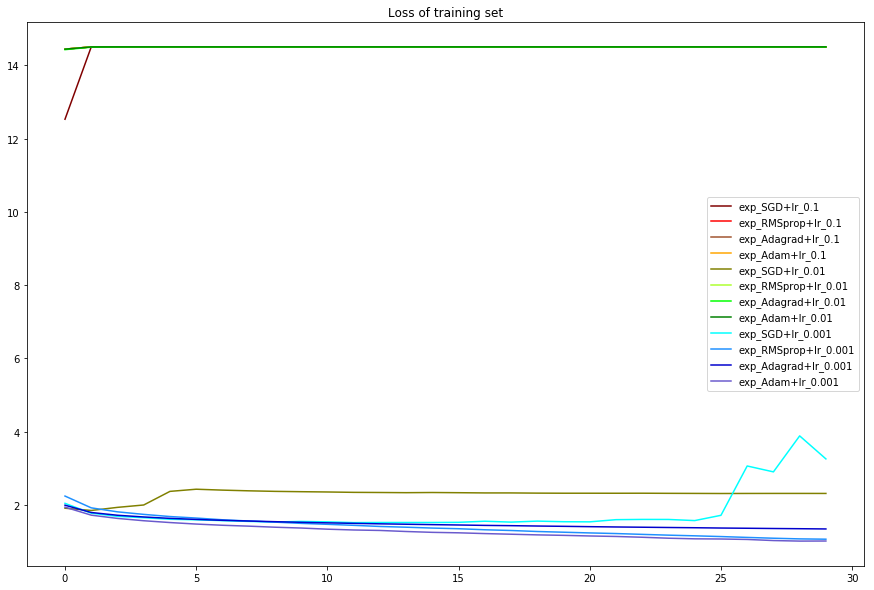

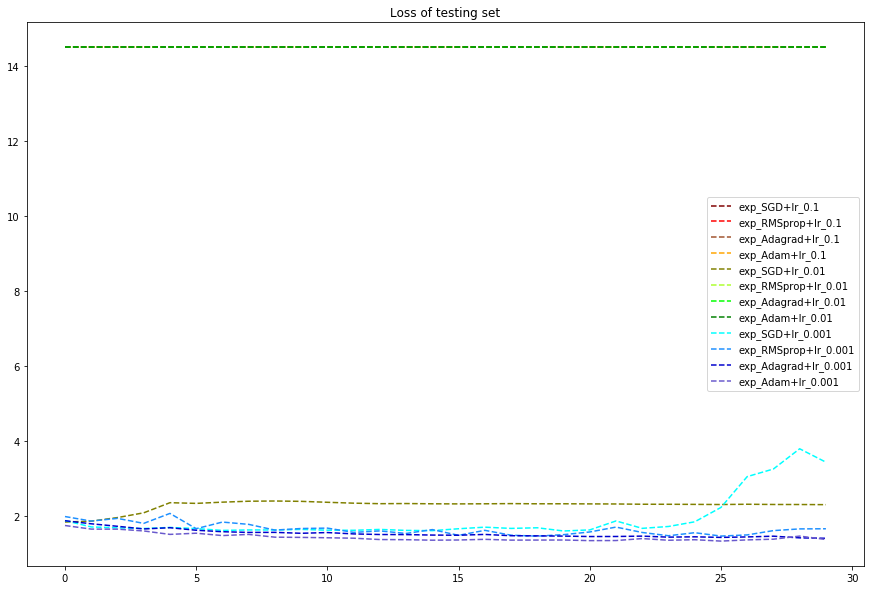

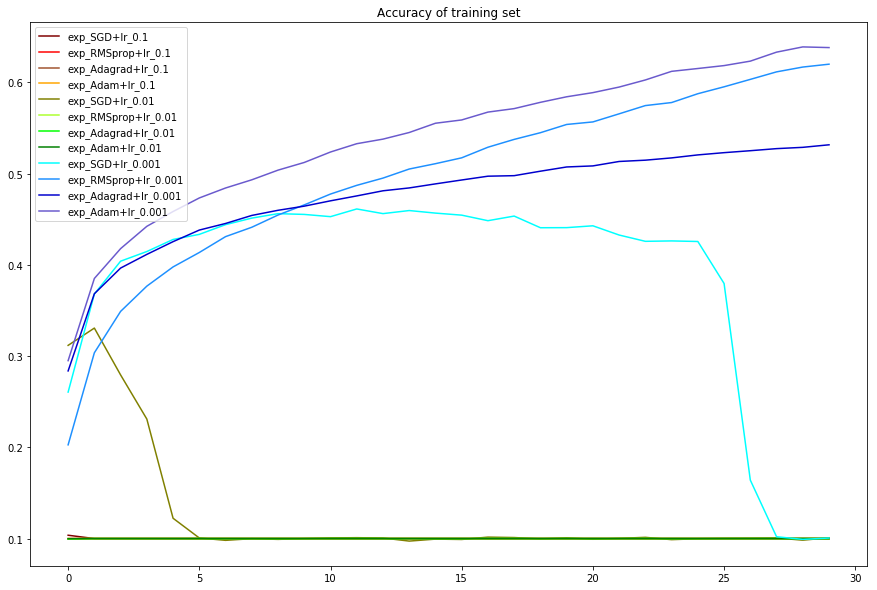

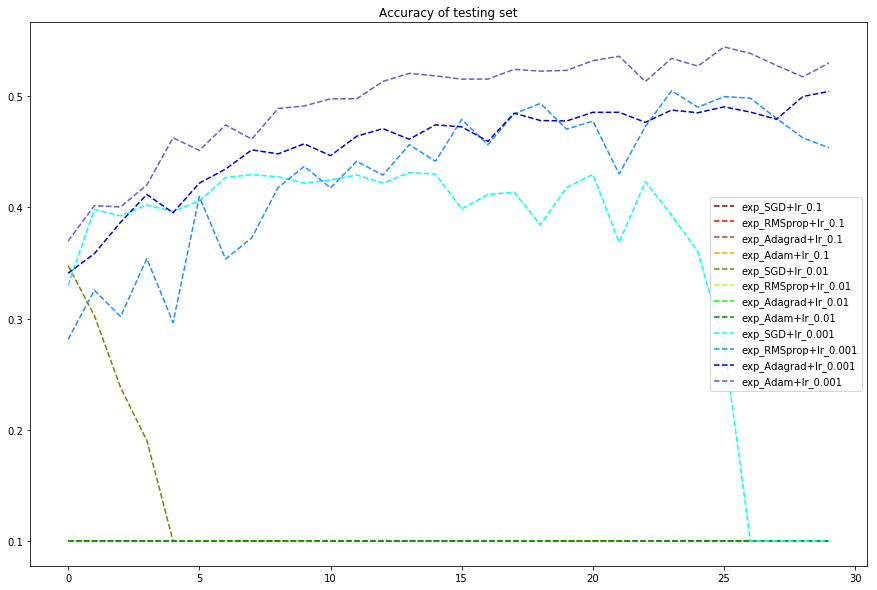

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar=['maroon','red','sienna','orange','olive','greenyellow','lime','green','aqua','dodgerblue','mediumblue','slateblue']
"""
將實驗結果繪出
"""
plt.figure(figsize=(15,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'],'-',label=cond,color=color_bar[i])
plt.title('Loss of training set')
plt.legend()

plt.figure(figsize=(15,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'],'--',label=cond,color=color_bar[i])
plt.title('Loss of testing set')
plt.legend()

plt.figure(figsize=(15,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'],'-',label=cond,color=color_bar[i])
plt.title('Accuracy of training set')
plt.legend()

plt.figure(figsize=(15,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'],'--',label=cond,color=color_bar[i])
plt.title('Accuracy of testing set')
plt.legend()